In [12]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Data wrangling

In [16]:
df = pd.read_csv('Wildfire.csv')
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'fire_name','disc_date_final','cont_date_final','cont_clean_date','putout_time'])
df

,fire_size,fire_size_class,stat_cause_descr,latitude,longitude,state,disc_clean_date,discovery_month,disc_date_pre,disc_pre_year,disc_pre_month,wstation_usaf,dstation_m,wstation_wban,wstation_byear,wstation_eyear,Vegetation,fire_mag,weather_file,Temp_pre_30,Temp_pre_15,Temp_pre_7,Temp_cont,Wind_pre_30,Wind_pre_15,Wind_pre_7,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness
0,10.0,C,Missing/Undefined,18.105072,-66.753044,PR,2/11/2007,Feb,1/12/2007,2007,Jan,785140,58917.697160,11603,1945,2018,12,1.0,785140-11603-2007.gz,24.480974,24.716923,24.902597,24.527961,4.341807,3.492857,3.262092,3.250413,78.216590,76.793750,76.381579,78.724370,0.0,0.0,0.0,0.0,0.017923
1,3.0,B,Arson,35.038330,-87.610000,TN,12/11/2006,Dec,11/11/2006,2006,Nov,723235,32665.343270,13896,1978,2020,15,0.1,723235-13896-2006.gz,7.553433,7.010000,0.343529,10.448298,2.709764,2.881707,1.976471,2.122320,70.840000,65.858911,55.505882,81.682678,59.8,8.4,0.0,86.8,0.184355
2,60.0,C,Arson,34.947800,-88.722500,MS,2/29/2004,Feb,1/30/2004,2004,Jan,723235,105122.149500,13896,1978,2020,16,1.0,723235-13896-2004.gz,4.971930,5.782766,5.558750,13.696600,3.364499,2.923830,2.695833,3.369050,75.531629,75.868613,76.812834,65.063800,168.8,42.2,18.1,124.5,0.194544
3,1.0,B,Debris Burning,39.641400,-119.308300,NV,6/6/2005,Jun,5/7/2005,2005,May,724880,43433.329780,23185,1942,2020,0,0.1,724880-23185-2005.gz,16.275967,18.996181,18.142564,0.000000,4.054982,3.398329,3.671282,0.000000,44.778429,37.140811,35.353846,0.000000,10.4,7.2,0.0,0.0,0.487447
4,2.0,B,Miscellaneous,30.700600,-90.591400,LA,9/22/1999,Sep,8/23/1999,1999,Aug,722312,25940.574090,3908,1987,2016,12,0.1,File Not Found,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.214633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55362,6289.0,G,Missing/Undefined,39.180000,-96.784167,KS,10/15/2015,Oct,9/15/2015,2015,Sep,724550,9004.604868,99999,2006,2020,0,100.0,724550-13947-2015.gz,19.720799,16.891282,18.918994,13.242324,3.259176,2.705398,3.196648,3.804803,65.671410,61.839572,54.625698,55.042092,35.4,8.2,0.0,249.0,0.331501
55363,70868.0,G,Missing/Undefined,38.342719,-120.695967,CA,9/9/2015,Sep,8/10/2015,2015,Aug,720681,22236.095780,99999,2010,2020,0,100.0,File Not Found,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.124683
55364,5702.0,G,Arson,37.262607,-119.511139,CA,7/25/2015,Jul,6/25/2015,2015,Jun,723897,64987.396810,99999,2006,2020,0,100.0,723897-99999-2015.gz,28.425403,28.425403,28.166667,27.646067,2.649395,2.649395,2.667722,2.529158,43.755556,43.755556,44.443975,35.924406,0.0,0.0,0.0,0.0,0.097682
55365,3261.0,F,Miscellaneous,40.604300,-123.080450,CA,7/31/2015,Jul,7/1/2015,2015,Jul,721027,53219.630130,99999,2012,2019,15,50.0,File Not Found,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.178206


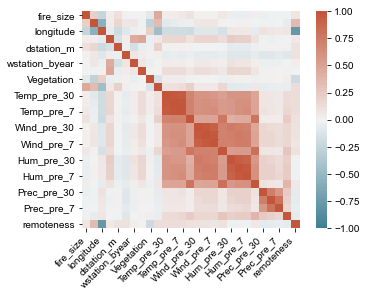

In [5]:
df_numerics_only = df.select_dtypes(include=np.number)

corr = df_numerics_only.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
sns.set(rc={'figure.figsize':(10,10)})

55367
41132


<AxesSubplot:>

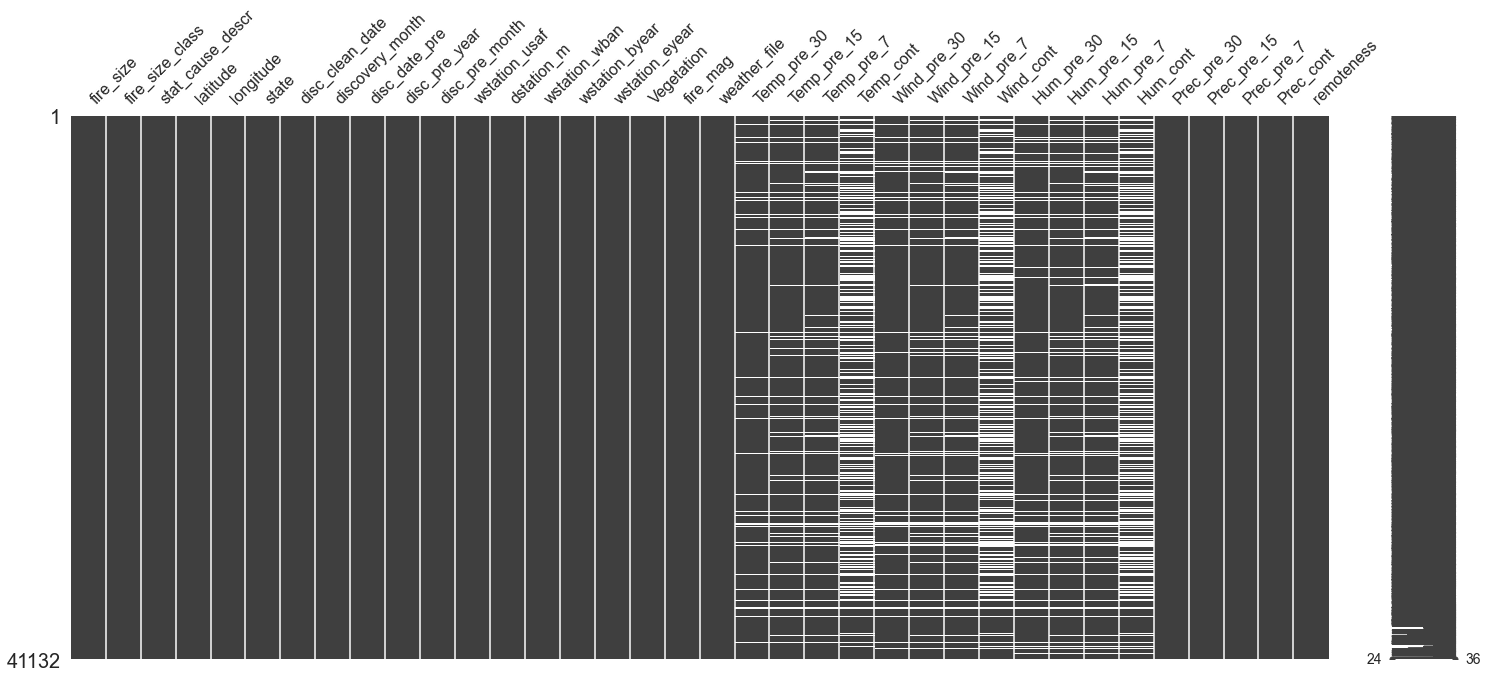

In [6]:
### Dealing with missing data
print(len(df))

# drop columns where weather file is missing
index = df[df['weather_file'] == 'File Not Found'].index
df.drop(index, inplace = True)
print(len(df))

# Weather data has a lot of 0 values some of which may be missing values
# So here we mark '0' values in weather columns as Na (to see how many there are)
subset = ['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont']
df[subset] = df[subset].replace({0:np.nan, '0':np.nan})
subset_neg1 = ['Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont']
df[subset_neg1] = df[subset_neg1].replace({-1:np.nan})

msno.matrix(df)


In [7]:
# Drop observations where all weather columns are 0
df = df.dropna(how='all',
                    subset=['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont'])
print(len(df))
# This leaves us with 38,689 observations to work with (originally we had 50,000)

# fill pre columns temp wind and humidity with mean values
subset_fill_mean = ['Temp_pre_30','Temp_pre_15','Temp_pre_7', 'Wind_pre_30','Wind_pre_15','Wind_pre_7', 'Hum_pre_30', 'Hum_pre_15','Hum_pre_7']
df[subset_fill_mean] = df[subset_fill_mean].fillna(df[subset_fill_mean].mean())

# Fill nas of current based on mean values from previous days
df['Temp_cont'] = df.apply(
    lambda row: (row['Temp_pre_7']+row['Temp_pre_15']+row['Temp_pre_30'])/3 if np.isnan(row['Temp_cont']) else row['Temp_cont'],
    axis=1)

df['Wind_cont'] = df.apply(
    lambda row: (row['Wind_pre_7']+row['Wind_pre_15']+row['Wind_pre_30'])/3 if np.isnan(row['Wind_cont']) else row['Wind_cont'],
    axis=1)

df['Hum_cont'] = df.apply(
    lambda row: (row['Hum_pre_7']+row['Hum_pre_15']+row['Hum_pre_30'])/3 if np.isnan(row['Hum_cont']) else row['Hum_cont'],
    axis=1)

38689


In [37]:
from datetime import datetime
import matplotlib.pyplot as plt

In [38]:
df['disc_clean_date'] = pd.to_datetime(df['disc_clean_date'], format='%m/%d/%Y')
df.head(4)

,fire_size,fire_size_class,stat_cause_descr,latitude,longitude,state,disc_clean_date,discovery_month,disc_date_pre,disc_pre_year,disc_pre_month,wstation_usaf,dstation_m,wstation_wban,wstation_byear,wstation_eyear,Vegetation,fire_mag,weather_file,Temp_pre_30,Temp_pre_15,Temp_pre_7,Temp_cont,Wind_pre_30,Wind_pre_15,Wind_pre_7,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness
0,10.0,C,Missing/Undefined,18.105072,-66.753044,PR,2007-02-11,Feb,1/12/2007,2007,Jan,785140,58917.69716,11603,1945,2018,12,1.0,785140-11603-2007.gz,24.480974,24.716923,24.902597,24.527961,4.341807,3.492857,3.262092,3.250413,78.216590,76.793750,76.381579,78.724370,0.0,0.0,0.0,0.0,0.017923
1,3.0,B,Arson,35.038330,-87.610000,TN,2006-12-11,Dec,11/11/2006,2006,Nov,723235,32665.34327,13896,1978,2020,15,0.1,723235-13896-2006.gz,7.553433,7.010000,0.343529,10.448298,2.709764,2.881707,1.976471,2.122320,70.840000,65.858911,55.505882,81.682678,59.8,8.4,0.0,86.8,0.184355
2,60.0,C,Arson,34.947800,-88.722500,MS,2004-02-29,Feb,1/30/2004,2004,Jan,723235,105122.14950,13896,1978,2020,16,1.0,723235-13896-2004.gz,4.971930,5.782766,5.558750,13.696600,3.364499,2.923830,2.695833,3.369050,75.531629,75.868613,76.812834,65.063800,168.8,42.2,18.1,124.5,0.194544
3,1.0,B,Debris Burning,39.641400,-119.308300,NV,2005-06-06,Jun,5/7/2005,2005,May,724880,43433.32978,23185,1942,2020,0,0.1,724880-23185-2005.gz,16.275967,18.996181,18.142564,17.804904,4.054982,3.398329,3.671282,3.708198,44.778429,37.140811,35.353846,39.091029,10.4,7.2,0.0,0.0,0.487447


In [8]:
#one hot encoding vegetation
df['Vegetation'] = df['Vegetation'].astype('category')

df = pd.get_dummies(df,prefix=['Vegetation'], columns = ['Vegetation'], drop_first=True)
df.head()

,fire_size,fire_size_class,stat_cause_descr,latitude,longitude,state,disc_clean_date,discovery_month,disc_date_pre,disc_pre_year,disc_pre_month,wstation_usaf,dstation_m,wstation_wban,wstation_byear,wstation_eyear,fire_mag,weather_file,Temp_pre_30,Temp_pre_15,Temp_pre_7,Temp_cont,Wind_pre_30,Wind_pre_15,Wind_pre_7,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness,Vegetation_4,Vegetation_9,Vegetation_12,Vegetation_14,Vegetation_15,Vegetation_16
0,10.0,C,Missing/Undefined,18.105072,-66.753044,PR,2/11/2007,Feb,1/12/2007,2007,Jan,785140,58917.69716,11603,1945,2018,1.0,785140-11603-2007.gz,24.480974,24.716923,24.902597,24.527961,4.341807,3.492857,3.262092,3.250413,78.216590,76.793750,76.381579,78.724370,0.0,0.0,0.0,0.0,0.017923,0,0,1,0,0,0
1,3.0,B,Arson,35.038330,-87.610000,TN,12/11/2006,Dec,11/11/2006,2006,Nov,723235,32665.34327,13896,1978,2020,0.1,723235-13896-2006.gz,7.553433,7.010000,0.343529,10.448298,2.709764,2.881707,1.976471,2.122320,70.840000,65.858911,55.505882,81.682678,59.8,8.4,0.0,86.8,0.184355,0,0,0,0,1,0
2,60.0,C,Arson,34.947800,-88.722500,MS,2/29/2004,Feb,1/30/2004,2004,Jan,723235,105122.14950,13896,1978,2020,1.0,723235-13896-2004.gz,4.971930,5.782766,5.558750,13.696600,3.364499,2.923830,2.695833,3.369050,75.531629,75.868613,76.812834,65.063800,168.8,42.2,18.1,124.5,0.194544,0,0,0,0,0,1
3,1.0,B,Debris Burning,39.641400,-119.308300,NV,6/6/2005,Jun,5/7/2005,2005,May,724880,43433.32978,23185,1942,2020,0.1,724880-23185-2005.gz,16.275967,18.996181,18.142564,17.804904,4.054982,3.398329,3.671282,3.708198,44.778429,37.140811,35.353846,39.091029,10.4,7.2,0.0,0.0,0.487447,0,0,0,0,0,0
6,5.2,B,Debris Burning,31.316978,-83.393649,GA,1/10/2009,Jan,12/11/2008,2008,Dec,747810,42972.94028,99999,2006,2020,0.1,747810-13857-2008.gz,14.877341,16.409326,16.918445,16.068371,2.000214,1.727202,3.142316,2.289911,79.896679,73.431818,58.542405,70.623634,26.0,0.0,0.0,0.0,0.148904,0,0,1,0,0,0


In [9]:
# selecting features and target variables
X = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont']]
y = df['fire_size']

X_norm = (X-X.min())/(X.max()-X.min())
y_norm = (y-y.min())/(y.max()-y.min())

#train test split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42)

## Modelling

In [ ]:
# Deccision trees
# Random forest
# PCA
# neural network
# XGboost

## Other

In [ ]:
# Get weather stations ordered by distance to Vancouver, BC
stations = Stations(lat = 38.843988, lon = -122.759707, daily = datetime(2018, 1, 1))
# Fetch closest station (limit = 1)
station = stations.fetch(1)

data = Daily(station, start = datetime(2018, 1, 1), end = datetime(2018, 1, 1))
# Fetch Pandas DataFrame
data = data.fetch()

data.plot(y=['tavg', 'tmin', 'tmax'])